In [ ]:
!pip install datasets transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BertTokenizer

In [ ]:
class Config:
    vocab_size = 30522
    hidden_size = 192
    num_hidden_layers = 12
    num_attention_heads = 12
    intermediate_size = 256
    max_position_embeddings = 128
    num_classes = 2

class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, device=input_ids.device).unsqueeze(0)
        token_embed = self.token_embeddings(input_ids)
        position_embed = self.position_embeddings(position_ids)
        embeddings = token_embed + position_embed
        return self.layer_norm(embeddings)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = config.num_attention_heads
        self.d_k = config.hidden_size // self.num_heads

        self.query = nn.Linear(config.hidden_size, config.hidden_size)
        self.key = nn.Linear(config.hidden_size, config.hidden_size)
        self.value = nn.Linear(config.hidden_size, config.hidden_size)
        self.out = nn.Linear(config.hidden_size, config.hidden_size)

    def forward(self, x, mask=None):
        batch_size, seq_length, hidden_size = x.size()

        Q = self.query(x).view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        K = self.key(x).view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        V = self.value(x).view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, V).transpose(1, 2).contiguous().view(batch_size, seq_length, hidden_size)
        return self.out(context)

class EncoderLayer(nn.Module):
    def __init__(self, config):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(config)
        self.norm1 = nn.LayerNorm(config.hidden_size)
        self.ff = nn.Sequential(
            nn.Linear(config.hidden_size, config.intermediate_size),
            nn.ReLU(),
            nn.Linear(config.intermediate_size, config.hidden_size)
        )
        self.norm2 = nn.LayerNorm(config.hidden_size)

    def forward(self, x, mask=None):
        attn = self.self_attention(x, mask)
        x = self.norm1(x + attn)
        ff = self.ff(x)
        return self.norm2(x + ff)

class MiniBERT(nn.Module):
    def __init__(self, config):
        super(MiniBERT, self).__init__()
        self.embeddings = BertEmbeddings(config)
        self.encoder = nn.ModuleList([EncoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)

    def forward(self, input_ids, mask=None):
        x = self.embeddings(input_ids)
        for layer in self.encoder:
            x = layer(x, mask)
        cls_token = x[:, 0, :]
        return self.classifier(cls_token)

In [ ]:
config = Config()
model = MiniBERT(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = load_dataset("imdb")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=config.max_position_embeddings)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch")
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total


Epoch 1/15, Train Loss: 0.6448, Test Accuracy: 0.6910
Epoch 2/15, Train Loss: 0.5626, Test Accuracy: 0.7132
Epoch 3/15, Train Loss: 0.5026, Test Accuracy: 0.7490
Epoch 4/15, Train Loss: 0.4271, Test Accuracy: 0.7725
Epoch 5/15, Train Loss: 0.3457, Test Accuracy: 0.7691
Epoch 6/15, Train Loss: 0.2528, Test Accuracy: 0.7627
Epoch 7/15, Train Loss: 0.1541, Test Accuracy: 0.7547
Epoch 8/15, Train Loss: 0.0828, Test Accuracy: 0.7499
Epoch 9/15, Train Loss: 0.0575, Test Accuracy: 0.7476
Epoch 10/15, Train Loss: 0.0298, Test Accuracy: 0.7314
Epoch 11/15, Train Loss: 0.0359, Test Accuracy: 0.7460
Epoch 12/15, Train Loss: 0.0327, Test Accuracy: 0.7479
Epoch 13/15, Train Loss: 0.0270, Test Accuracy: 0.7526
Epoch 14/15, Train Loss: 0.0263, Test Accuracy: 0.7519
Epoch 15/15, Train Loss: 0.0248, Test Accuracy: 0.7520


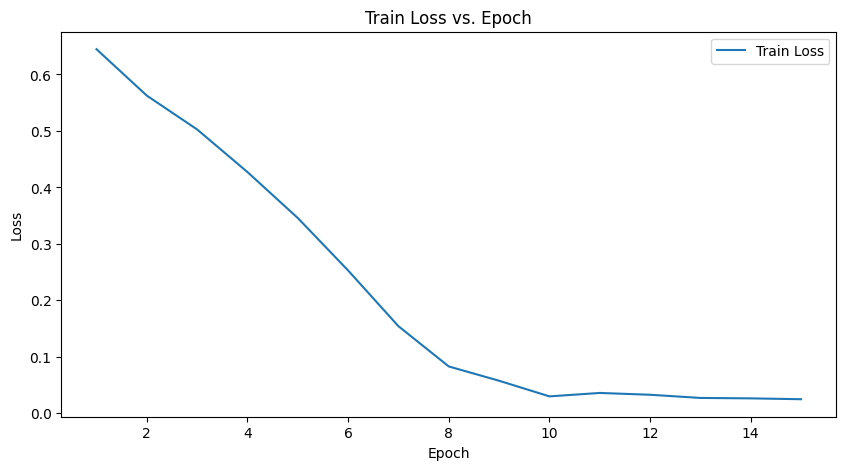

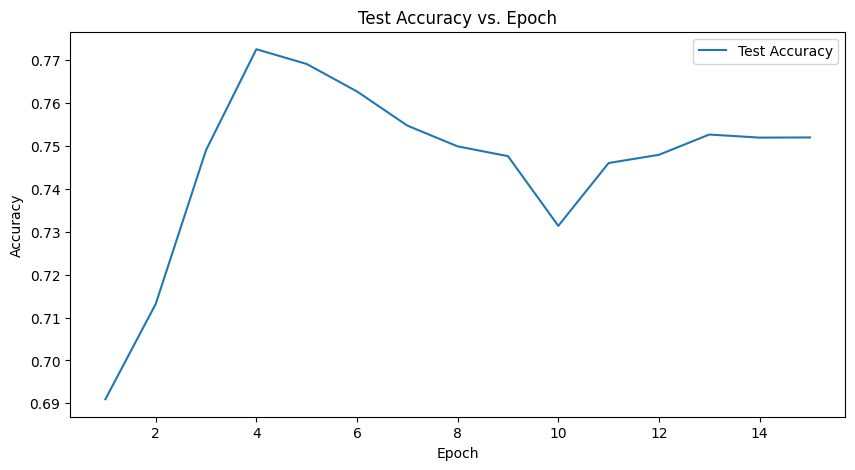

In [ ]:
import matplotlib.pyplot as plt

epochs = 15
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_accuracy = evaluate(model, test_loader, device)

    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs. Epoch')
plt.legend()
plt.show()

Matriz de Confusão:
[[9520 2980]
 [3221 9279]]


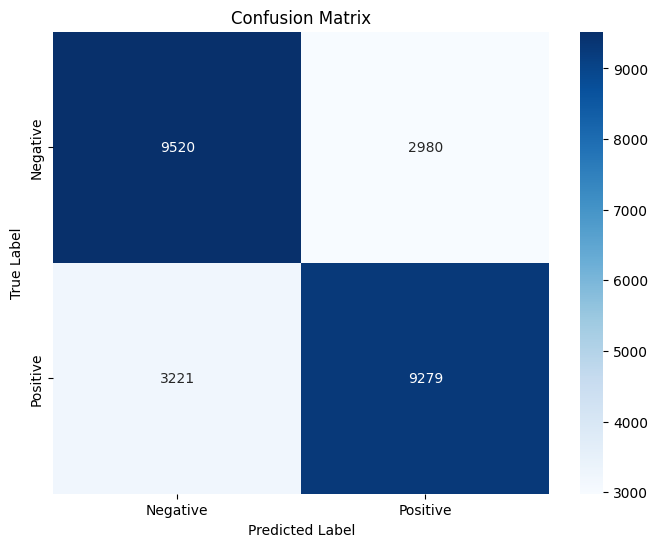

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_with_confusion_matrix(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    return cm

cm = evaluate_with_confusion_matrix(model, test_loader, device)
print("Matriz de Confusão:")
print(cm)

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
examples = test_dataset.shuffle(seed=42).select(range(10))

In [ ]:

for i, example in enumerate(examples):
    text = example["text"]
    true_label = example["label"]

    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities).item()

    print(f"Exemplo {i + 1}:")
    print(f"Texto: {text[:100]}...")
    print(f"Classe Prevista: {'Positivo' if predicted_class == 1 else 'Negativo'}")
    print(f"Classe Real: {'Positivo' if true_label == 1 else 'Negativo'}")
    print(f"Probabilidades: {probabilities.tolist()}")
    print("-" * 50)

Exemplo 1:
Texto: <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining Kin...
Classe Prevista: Positivo
Classe Real: Positivo
Probabilidades: [[0.002774575725197792, 0.9972254037857056]]
--------------------------------------------------
Exemplo 2:
Texto: This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French a...
Classe Prevista: Negativo
Classe Real: Positivo
Probabilidades: [[0.600924551486969, 0.399075448513031]]
--------------------------------------------------
Exemplo 3:
Texto: This movie was so frustrating. Everything seemed energetic and I was totally prepared to have a good...
Classe Prevista: Negativo
Classe Real: Negativo
Probabilidades: [[0.9198299050331116, 0.08017008006572723]]
--------------------------------------------------
Exemplo 4:
Texto: I was truly and wonderfully surprised at "O' Brother, Where Art Thou?" The video store was out of al...
Classe Prevista: Positivo
Classe Real